In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

# Chapter 3 - Inferences with binomials
## 3.1 Inferring a rate


Inferring the rate $\theta$ of a binary process  
$$ \theta \sim \text{Beta}(1, 1)  $$
$$ k \sim \text{Binomial} ( \theta, n)  $$

In the example, we set k = 5 and n = 10

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:00<00:00, 1418.60it/s]


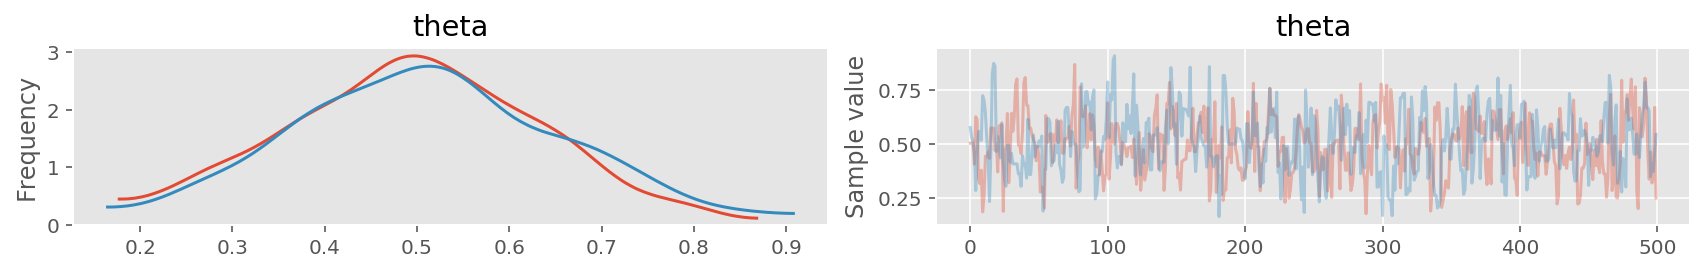

In [2]:
# Data
k = np.array([5])
n = np.array([10])

with pm.Model() as model1:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    # observed
    x = pm.Binomial('x', n=n, p=theta, observed=k)
    # inference
    trace1 = pm.sample()

pm.traceplot(trace1, varnames=['theta']);

And generate a picture that is identical to 3.2 one on page 39 of Wagenmakers, 2013:

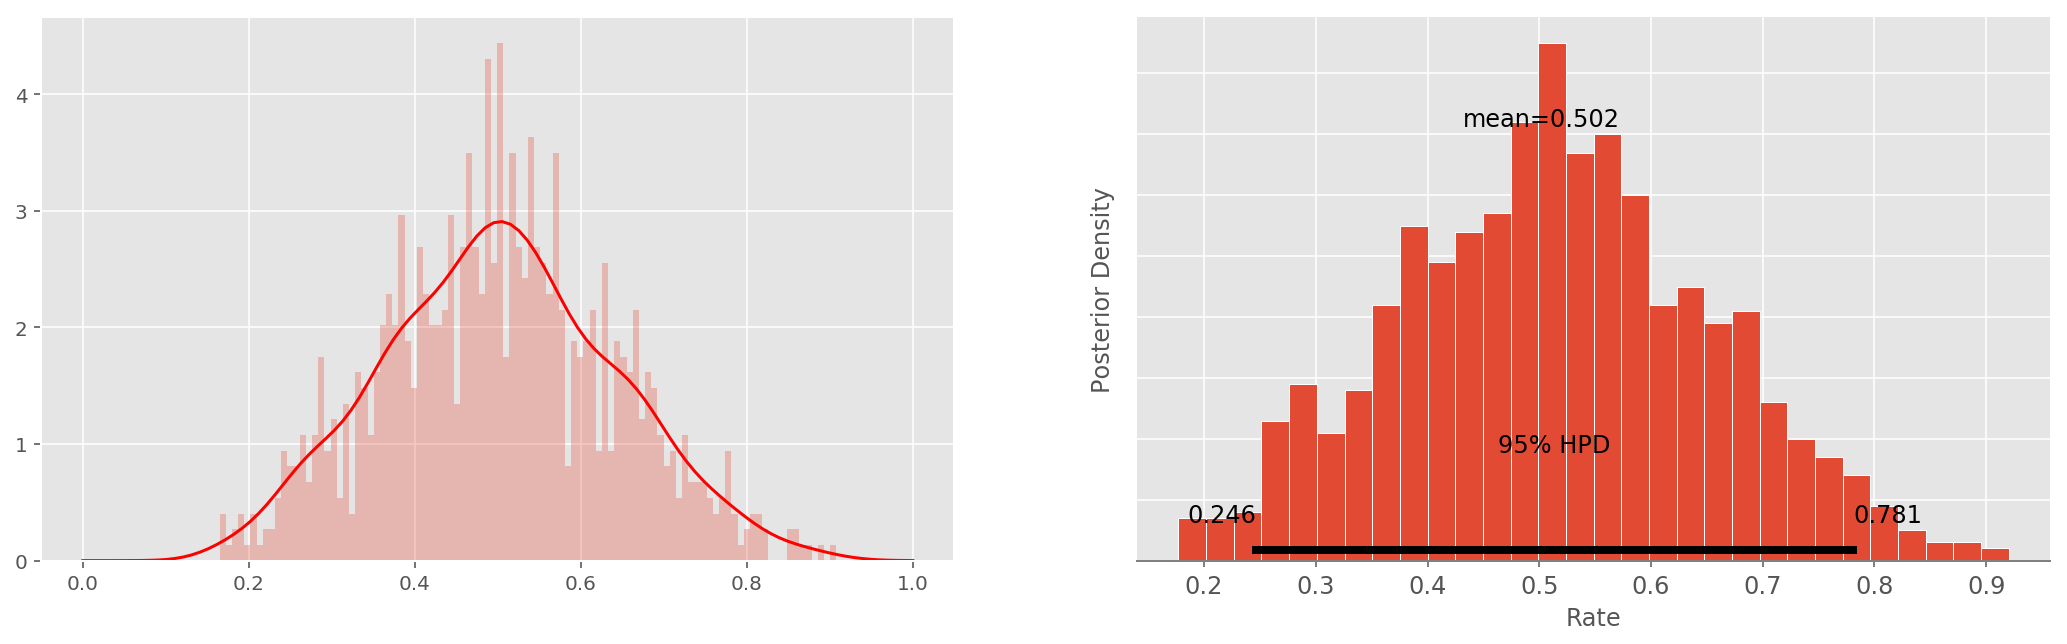

In [3]:
from scipy.stats.kde import gaussian_kde   # for plotting: to calculate a continuous 
                                           # approximation of the posterior and prior densities. 

my_pdf = gaussian_kde(trace1['theta'])
x = np.linspace(0, 1, 100)
_, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].plot(x, my_pdf(x), 'r') # distribution function
axes[0].hist(trace1['theta'], bins=100, normed=1, alpha=.3)
plt.xlabel('Rate')
plt.ylabel('Posterior Density')

pm.plot_posterior(trace1['theta'], ax=axes[1]);

In [4]:
pm.summary(trace1, varnames=['theta']).round(3)# gives the same credible interval as in the book.

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.502,0.139,0.006,0.246,0.781,399.0,1.002


## 3.2 Difference between two rates

Inferring the rate $\theta$ of two binary process  
$$ \theta \sim \text{Beta}(1, 1)  $$
$$ k \sim \text{Binomial} ( \theta, n)  $$

In the example, we set k1 = 5, n1 = 10 and k2 = 7, n2 = 10 

The model involve a deterministic part in pymc3.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1000/1000 [00:01<00:00, 782.66it/s]


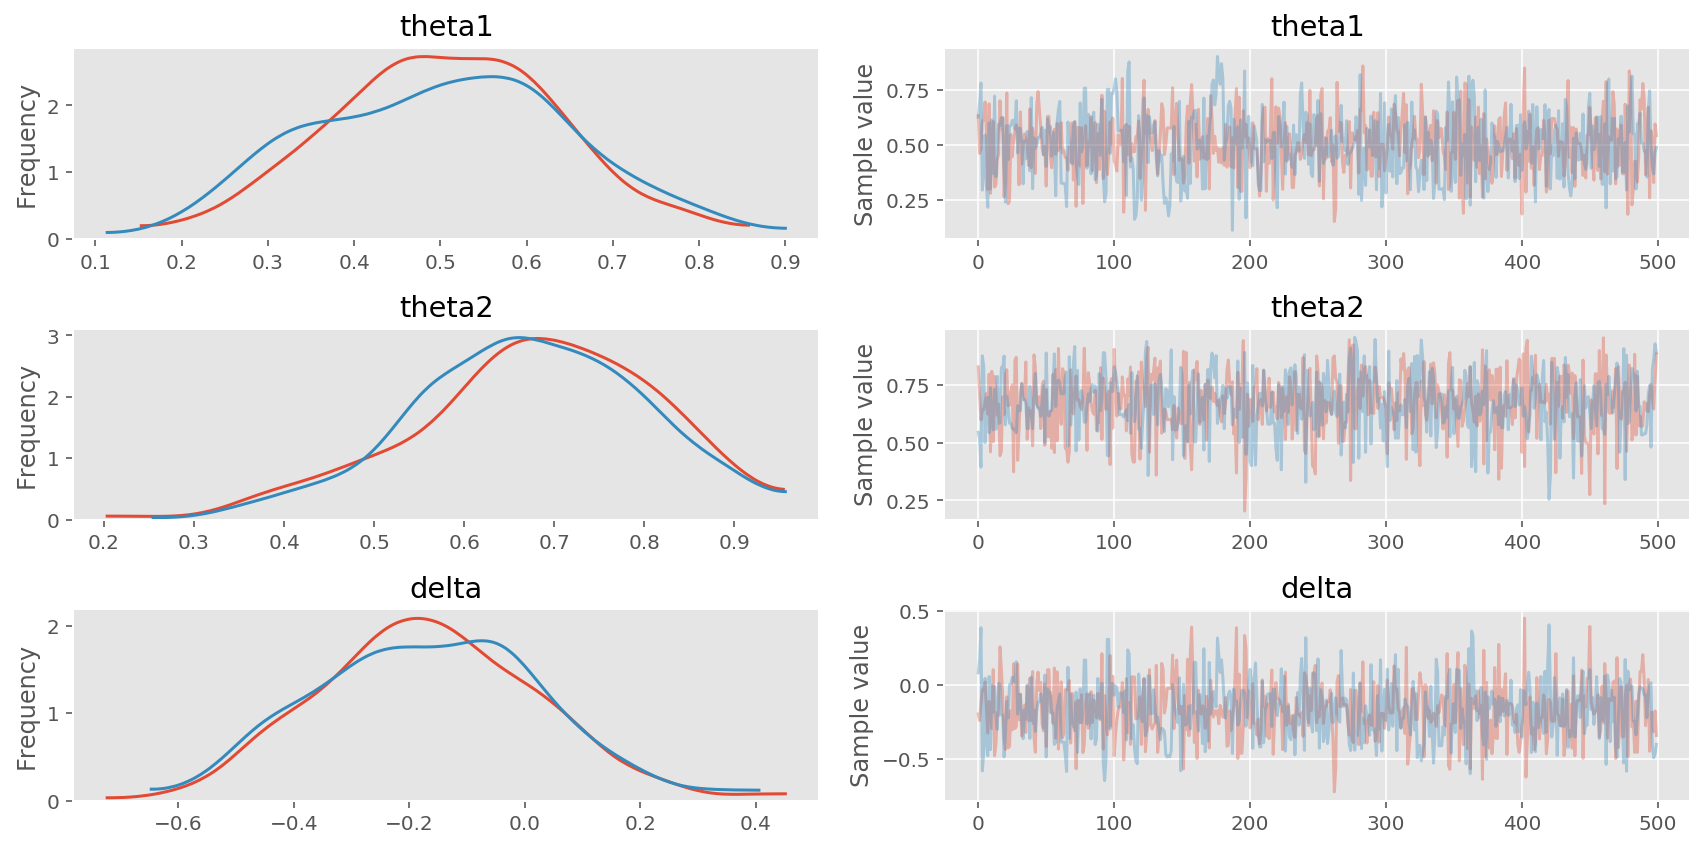

In [5]:
# data
k1, k2 = 5, 7
n1 = n2 = 10

with pm.Model() as model2:
    # prior
    theta1 = pm.Beta('theta1', alpha=1, beta=1)
    theta2 = pm.Beta('theta2', alpha=1, beta=1)
    # observed
    x1 = pm.Binomial('x1', n=n1, p=theta1, observed=k1)
    x2 = pm.Binomial('x2', n=n2, p=theta2, observed=k2)
    # differences as deterministic
    delta = pm.Deterministic('delta', theta1-theta2)
    # inference
    trace2 = pm.sample()

pm.traceplot(trace2);

In [6]:
pm.summary(trace2).round(3)# gives the credible interval

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.504,0.141,0.005,0.241,0.783,898.0,0.999
theta2,0.672,0.130,0.004,0.414,0.909,1000.0,0.999
delta,-0.168,0.191,0.006,-0.503,0.212,1000.0,0.999


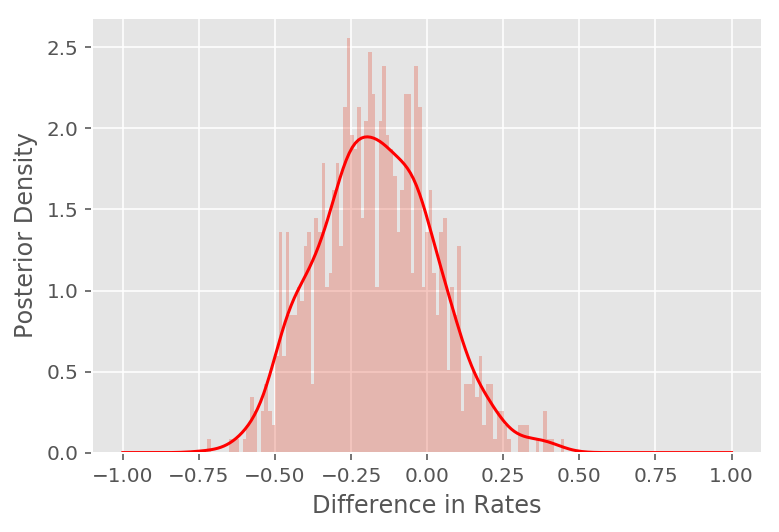

In [7]:
my_pdf = gaussian_kde(trace2['delta'])
x = np.linspace(-1, 1, 200)
plt.plot(x, my_pdf(x), 'r') # distribution function

plt.hist(trace2['delta'], bins=100, normed=1, alpha=.3)
plt.xlabel('Difference in Rates')
plt.ylabel('Posterior Density');

## 3.3 Inferring a common rate

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500.0 [00:00<00:00, 1668.63it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.597,0.101,0.003,0.404,0.8,827.0,1.0


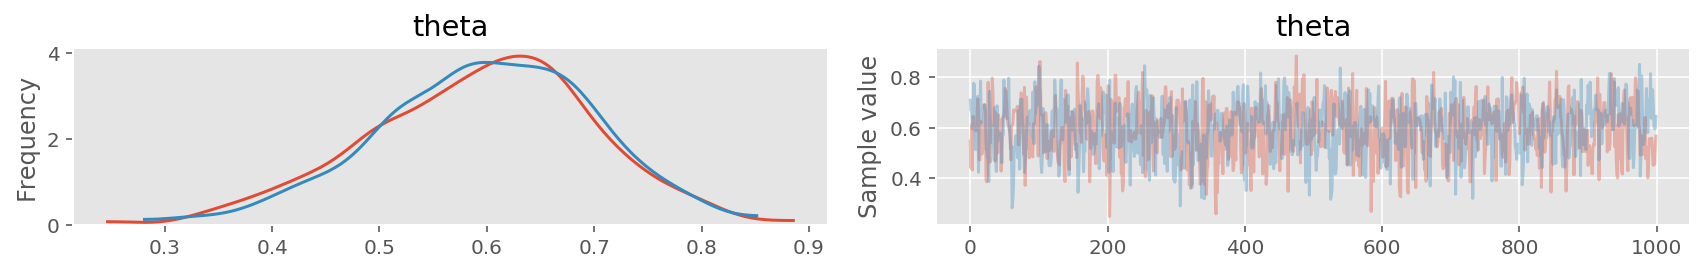

In [8]:
# Multiple trials
k = np.array([5, 7])
n = np.array([10, 10])

with pm.Model() as model3:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    # observed
    x = pm.Binomial('x', n=n, p=theta, observed=k)
    # inference
    trace3 = pm.sample(1e3, njobs=2)

pm.traceplot(trace3, varnames=['theta']);
pm.summary(trace3).round(3)

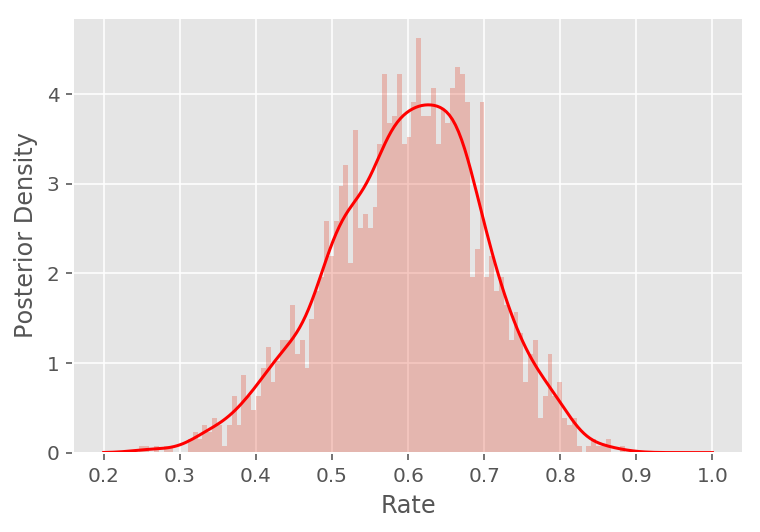

In [9]:
my_pdf = gaussian_kde(trace3['theta'])
x = np.linspace(0.2, 1, 200)
plt.plot(x, my_pdf(x), 'r') # distribution function

plt.hist(trace3['theta'], bins=100, normed=1, alpha=.3)
plt.xlabel('Rate')
plt.ylabel('Posterior Density');

## 3.4 Prior and posterior prediction

In [10]:
k = 1
n = 15
# Uncomment for Trompetter Data
# k = 24
# n = 121

# prior only model - no observation
with pm.Model() as model_prior:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Binomial('x', n=n, p=theta)
    trace_prior = pm.sample()
    
# with observation
with pm.Model() as model_obs:
    theta = pm.Beta('theta', alpha=1, beta=1)
    x = pm.Binomial('x', n=n, p=theta, observed=k)
    trace_obs = pm.sample()
    
# prediction (sample from trace)
ppc = pm.sample_ppc(trace_obs, samples=500, model=model_obs)

Assigned NUTS to theta_logodds__
Assigned Metropolis to x
 90%|████████▉ | 899/1000 [00:00<00:00, 981.12it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.907051177973, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 1000/1000 [00:01<00:00, 995.50it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 500/500 [00:00<00:00, 1751.04it/s]


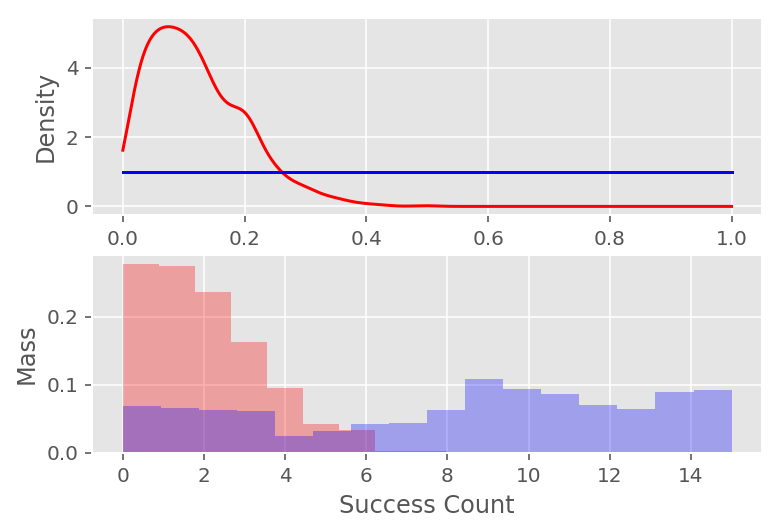

In [11]:
prior_x = trace_prior['x']
pred_theta = trace_obs['theta']

plt.subplot(2, 1, 1)
my_pdf = gaussian_kde(pred_theta)
x = np.linspace(0, 1, 1000)
plt.plot(x, my_pdf(x), 'r', label='Posterior') # distribution function
from scipy.stats import beta
plt.plot(x, beta.pdf(x, 1, 1), 'b', label='Prior')
plt.xlabel('Rate')
plt.ylabel('Density')

predictx = ppc['x']
plt.subplot(2, 1, 2)
plt.hist(predictx, normed=1, bins=len(np.unique(predictx)), 
         alpha=.3, color='r', label='Posterior')
plt.hist(prior_x, normed=1, bins=n+1, 
         alpha=.3, color='b', label='Prior')
plt.xlabel('Success Count')
plt.ylabel('Mass');

## 3.5 Posterior Predictive

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 500/500 [00:00<00:00, 2610.92it/s]


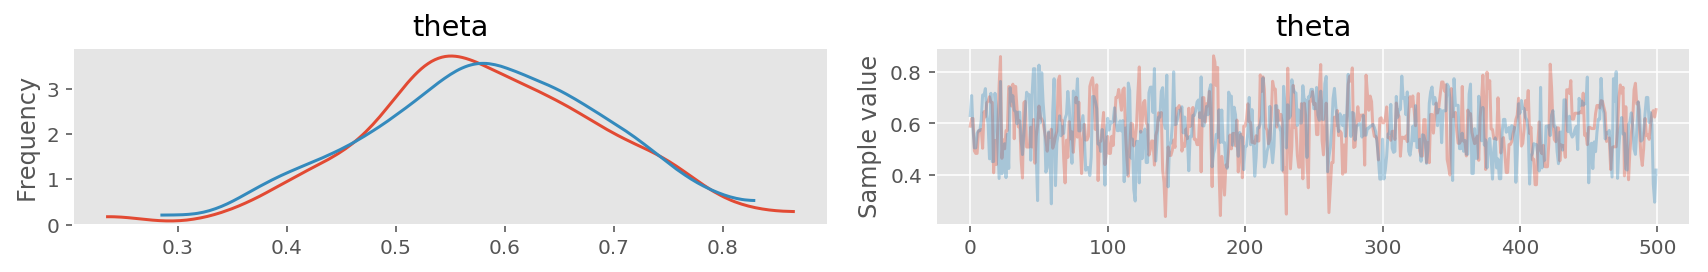

In [12]:
# Inferring a Common Rate, With Posterior Predictive
k1 = 2
n1 = 13
k2 = 10
n2 = 10

with pm.Model() as model5:
    # prior
    theta = pm.Beta('theta', alpha=1, beta=1)
    # observed
    x1 = pm.Binomial('x1', n=n2, p=theta, observed=k1)
    x2 = pm.Binomial('x2', n=n2, p=theta, observed=k2)
    # inference
    trace5 = pm.sample()

pm.traceplot(trace5, varnames=['theta']);
# prediction (sample from trace)
ppc5 = pm.sample_ppc(trace5, samples=500, model=model5)

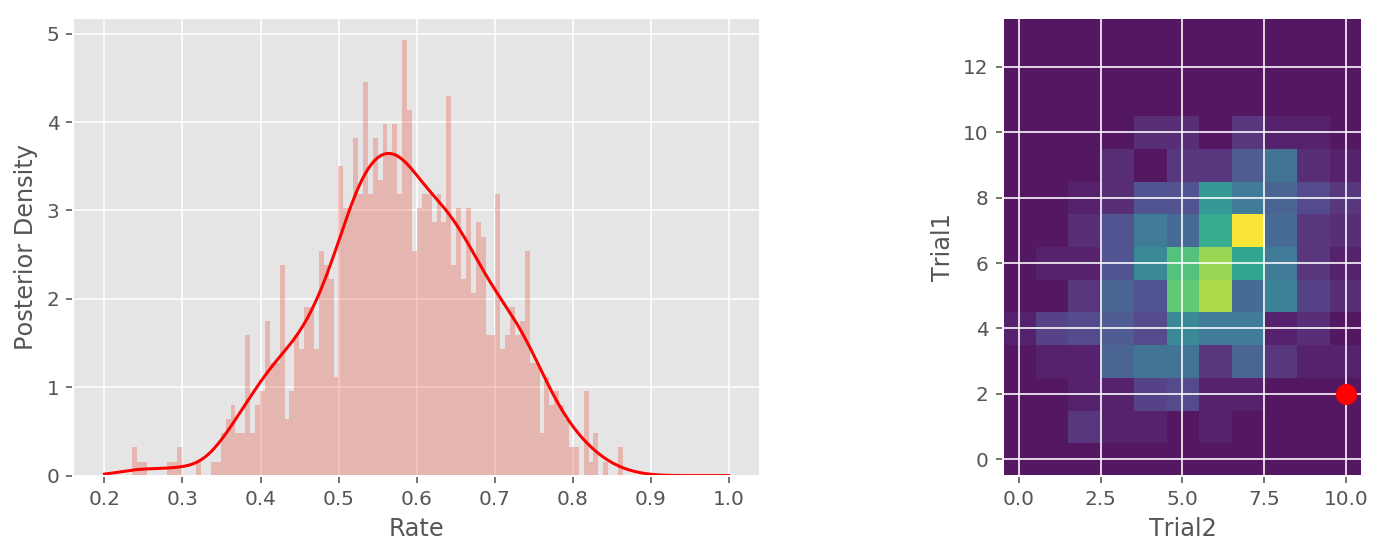

In [13]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 4)) 
gs = gridspec.GridSpec(1,2, width_ratios=[2, 3]) 
ax0 = plt.subplot(gs[0])

my_pdf = gaussian_kde(trace5['theta'])
x = np.linspace(0.2, 1, 200)
ax0.plot(x, my_pdf(x), 'r') # distribution function

ax0.hist(trace5['theta'], bins=100, normed=1, alpha=.3)
plt.xlabel('Rate')
plt.ylabel('Posterior Density')

ax1 = plt.subplot(gs[1])
predx1 = ppc5['x1']
predx2 = ppc5['x2']

from scipy import sparse
A = sparse.csc_matrix((np.ones(len(predx1)), (predx1,predx2)), 
                      shape=(n1+1,n2+1)).todense()
ax1.imshow(A, interpolation='none', alpha=.9, origin='lower')
ax1.scatter(k2, k1, s=100, c=[1,0,0])
plt.xlabel('Trial2')
plt.ylabel('Trial1')
plt.tight_layout()

## 3.6 Joint distributions

Assigned NUTS to theta_logodds__
Assigned Metropolis to TotalN
 82%|████████▏ | 8597/10500.0 [00:15<00:02, 920.92it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.692273385823, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
 99%|█████████▉| 10412/10500.0 [00:17<00:00, 933.34it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.935415539706, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 10500/10500.0 [00:17<00:00, 593.23it/s]


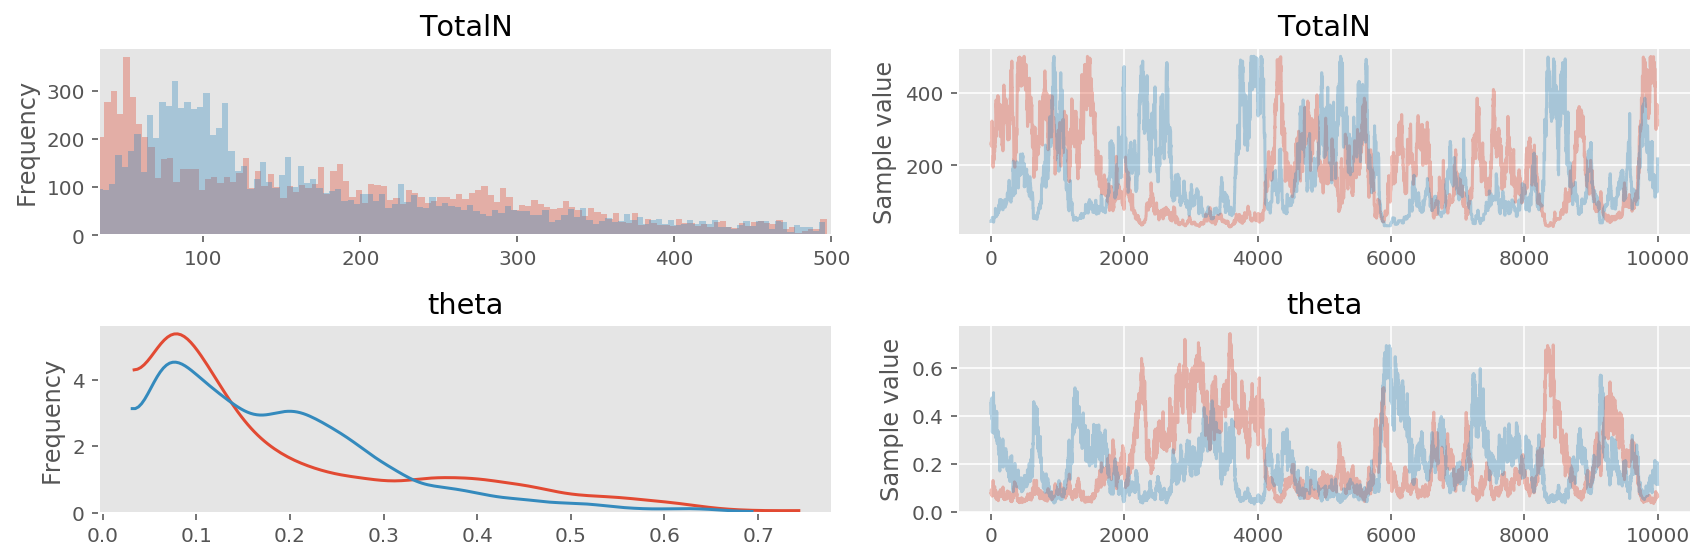

In [14]:
# the Survey example in the book
k = np.array([16, 18, 22, 25, 27])
nmax = 500
m = len(k)
    
with pm.Model() as model6:
    # prior
    theta = pm.Beta('theta', alpha=1,beta=1)
    TotalN = pm.DiscreteUniform('TotalN', lower=1, upper=nmax)
    # observed
    x = pm.Binomial('x', n=TotalN, p=theta, observed=k)
    # inference
    trace6 = pm.sample(1e4, njobs=2)

pm.traceplot(trace6);

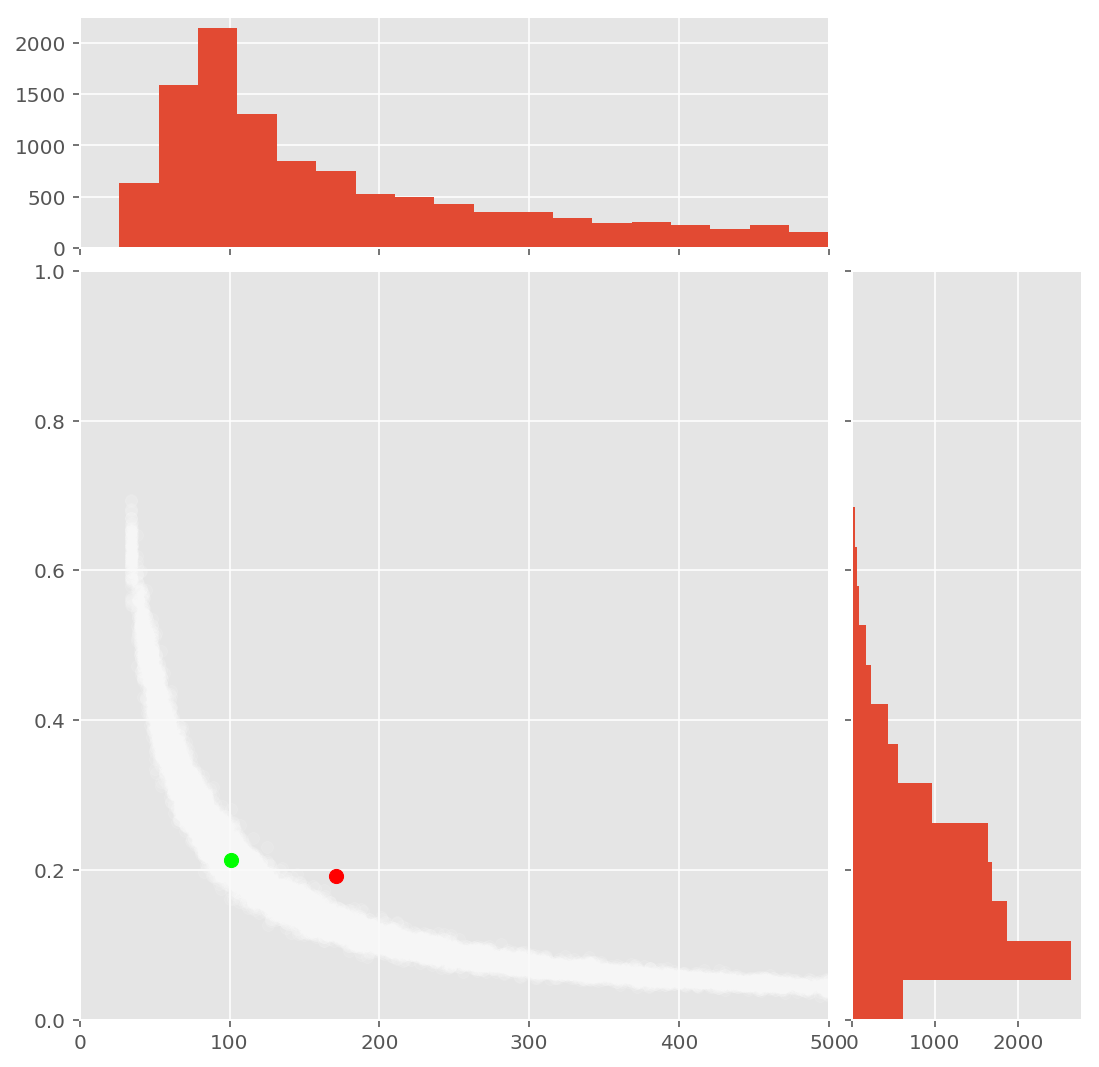

In [15]:
# First calculate MLE:
from scipy.special import *

burnin = 9000
thetapost = trace6['theta'][burnin:]
npost = trace6['TotalN'][burnin:]
cc = -float('Inf')
ind = 0

for i in range(0, len(npost)):
    logL = 0
    for j in k:   
        logL = logL+gammaln(npost[i]+1)-gammaln(j+1)-gammaln(npost[i] - j +1)
        logL = logL+j*np.log(thetapost[i])+(npost[i]-j)*np.log(1-thetapost[i])
    
    if logL > cc: 
        ind = i
        cc = logL
        
# print(ind)

from matplotlib.ticker import NullFormatter
def hist_marginal(x, y):
    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(8, 8))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y, c=[1, 1, 1], alpha=.1)
    axScatter.scatter(np.mean(x), np.mean(y), s=50, c=[1, 0, 0], alpha=1)
    axScatter.scatter(x[ind], y[ind], s=50, c=[0, 1, 0], alpha=1)

    # now determine nice limits by hand:
    binwidth1 = 0.25
    axScatter.set_xlim((0, nmax))
    axScatter.set_ylim((0, 1))

    bins1 = np.linspace(0, nmax, 20)
    axHistx.hist(x, bins=bins1)
    bins2 = np.linspace(0, 1, 20)
    axHisty.hist(y, bins=bins2, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    plt.show()
    
hist_marginal(x = npost, y = thetapost)

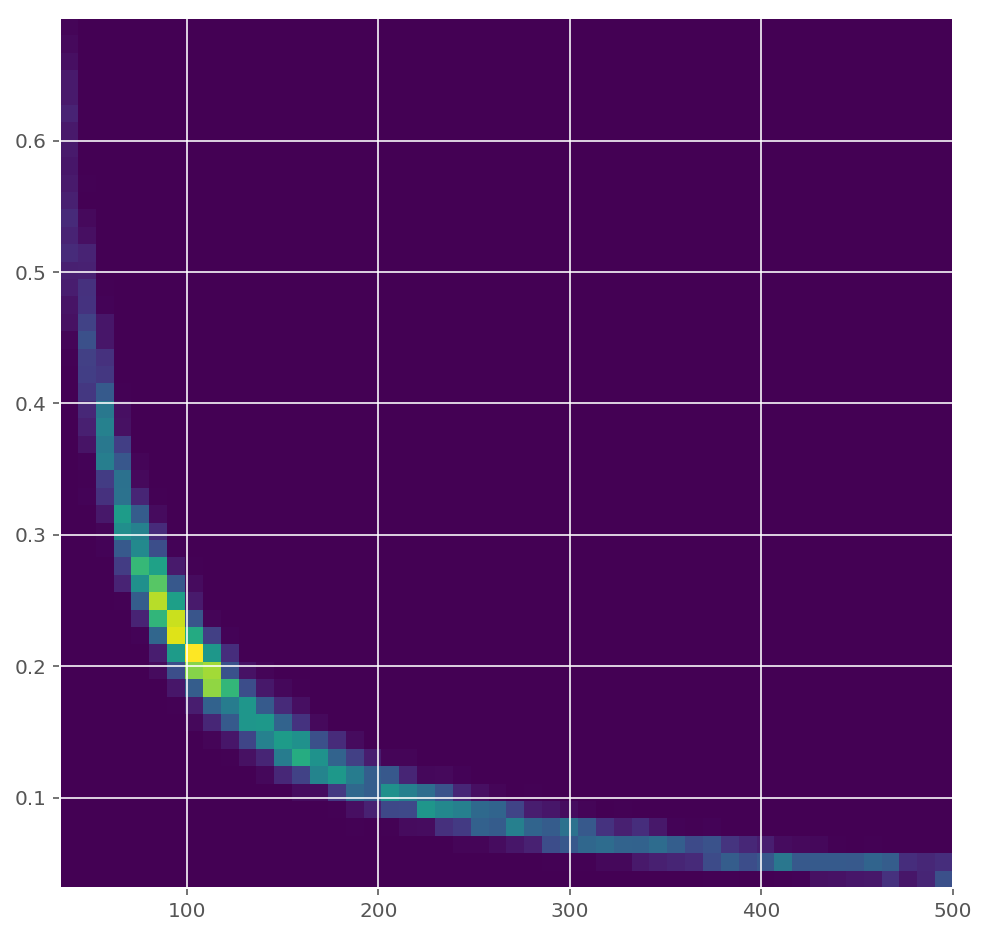

In [16]:
plt.figure(1, figsize=(8, 8))
plt.hist2d(npost, thetapost, bins=50);

### Note from Junpeng Lao
It is obvious from the above posterior plot that the geometry of the posterior is quite nasty. We can see that in the trace as well: the mixing is quite poor, with strong autocorrelation. There is no divergence warning, but it could just be that PyMC3 is mixing Metropolis and NUTS together due to the discrete variable. 
In this particular case, it is not a big deal as we can visualize the posterior directly. However, when we are sampling larger model, it is definitely going to be a problem.
Actually, we don't necessary need to use DiscreteUniform for TotalN, as the computation of logp in Binomial doesn't require n to be int.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 94%|█████████▍| 1887/2000.0 [00:28<00:01, 62.62it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 3 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 98%|█████████▊| 1968/2000.0 [00:29<00:00, 77.27it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 2 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 1991/2000.0 [00:29<00:00, 89.52it/s]/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/jlao/Documents/Github/pymc3/pymc3/step_methods/

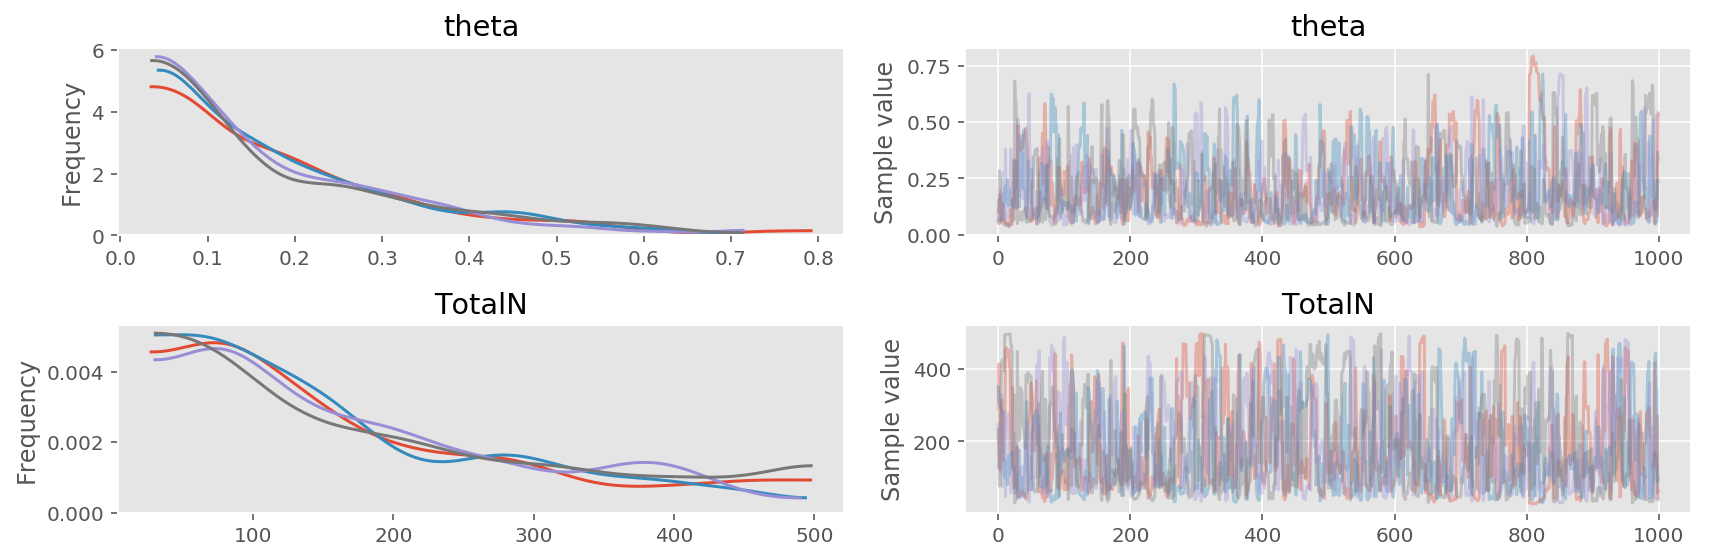

In [17]:
with pm.Model() as model6_:
    # prior
    theta = pm.Beta('theta', alpha=1,beta=1)
    TotalN = pm.Uniform('TotalN', lower=1, upper=nmax)
    # observed
    x = pm.Binomial('x', n=TotalN, p=theta, observed=k)
    # inference
    trace6_ = pm.sample(1e3, tune=1000, njobs=4, nuts_kwargs = {'target_accept' : 0.99})

pm.traceplot(trace6_);

Not too surprisingly, we can see divergence warnings. We can further visualize them:

Number of Divergent 8
Percentage of Divergent 0.00800


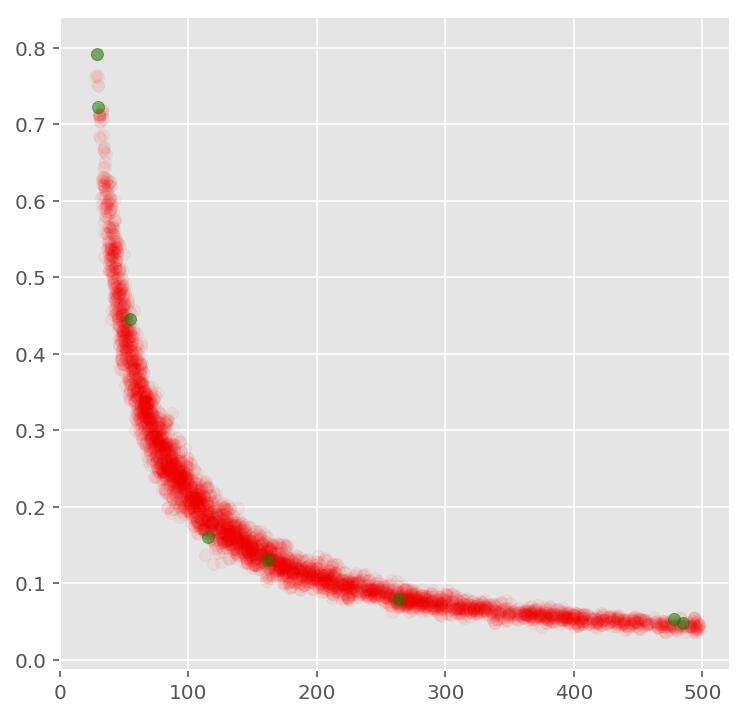

In [18]:
# display the total number and percentage of divergent
divergent = trace6_['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(trace6_)
print('Percentage of Divergent %.5f' % divperc)

# scatter plot between theta and N
# for the identifcation of the problematic neighborhoods in parameter space
theta_tr = trace6_['theta']
totaln_tr = trace6_['TotalN']
plt.figure(figsize=(6, 6))
plt.scatter(totaln_tr[divergent == 0], theta_tr[divergent == 0], color='r', alpha=.05)
plt.scatter(totaln_tr[divergent == 1], theta_tr[divergent == 1], color='g', alpha=.5);

It confirms our intuition that in the high curvature area (tails), our sampler is going to have difficulties.